In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import os
import json
from mplsoccer import * 
from pandas import json_normalize
import matplotlib

In [23]:
headers = {
    'accept': '*/*',
    'accept-language': 'es-ES,es;q=0.9,en;q=0.8',
    'cache-control': 'no-cache',
    # 'cookie': '_gcl_au=1.1.495834952.1723458264; _lr_env_src_ats=false; _ga=GA1.1.19138556.1723458265; __qca=P0-109151881-1723458265493; FCCDCF=%5Bnull%2Cnull%2Cnull%2C%5B%22CQDPSUAQDPSUAEsACCESBBFgAAAAAEPgAA6IAAARvADyFyImkKCwPCqQRYIQAIvgAAARYBAAAwCAgACgCUgAQgEIMAAABAAAEAAAAAAQIgCQAIAABAAAAAAAAAAQAAIAAAgAAAQQEAAAAAAAACAAAAQAAAAIAABgEAACAABghCIASQAkLAAAABAAAAABQAAAAAABAAAAJCAAAIAAAAAAAAAIACAIAAAAAAAACCQAAA.YAAACAgAAAA%22%2C%222~~dv.70.89.108.149.211.313.358.415.486.540.621.981.1029.1046.1092.1097.1126.1205.1301.1516.1558.1584.1598.1651.1697.1716.1753.1810.1832.1985.2328.2373.2440.2571.2572.2575.2577.2628.2642.2677.2767.2860.2878.2887.2922.3182.3190.3234.3290.3292.3331.10631%22%2C%22AE8E1037-F7D6-407F-8D2F-988E89EC6F3E%22%5D%5D; _lr_retry_request=true; __eoi=ID=9f8537f9af01cb0d:T=1723458279:RT=1723533307:S=AA-AfjaqhVdt3IWTf-fNI4tVNXga; gcid_first=95af7183-7c4b-49d4-a3fa-39ebecbaec50; _ga_3KF4XTPHC4=GS1.1.1723530800.2.1.1723533298.58.0.0; _ga_QH2YGS7BB4=GS1.1.1723530800.2.1.1723533298.0.0.0; _ga_HNQ9P9MGZR=GS1.1.1723530801.2.1.1723533299.0.0.0',
    'pragma': 'no-cache',
    'priority': 'u=1, i',
    'referer': 'https://www.sofascore.com/es/torneo/futbol/spain/laliga-2/54',
    'sec-ch-ua': '"Not)A;Brand";v="99", "Google Chrome";v="127", "Chromium";v="127"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36',
    'x-requested-with': '49530f',
}

In [24]:
#teamnName variable and data links for both graphs
team = "Real Zaragoza"
sofascore_2223 = requests.get('https://www.sofascore.com/api/v1/unique-tournament/54/season/42410/team/2815/team-performance-graph-data', headers=headers)
sofascore_2324 = requests.get('https://www.sofascore.com/api/v1/unique-tournament/54/season/52563/team/2815/team-performance-graph-data', headers=headers)
sofascore_2425 = requests.get('https://www.sofascore.com/api/v1/unique-tournament/54/season/62048/team/2815/team-performance-graph-data', headers=headers)
fotmob_2223 = "https://www.fotmob.com/en-GB/leagues/140/matches/laliga2?group=by-team&team=8394&season=2022-2023&page=1"
fotmob_2324 = "https://www.fotmob.com/en-GB/leagues/140/matches/laliga2?group=by-team&team=8394&season=2023-2024&page=1"
fotmob_2425 = "https://www.fotmob.com/en-GB/leagues/140/matches/laliga2?group=by-team&page=1&team=8394"

In [25]:
#cols for the df
columnas = ['match_id', 'week', 'position', 'tournament_name', 'homeTeam_name', 'homeScore', 'awayTeam_name',
       'awayScore']

In [26]:
#func to extract data from sofascore
def extract_match_data(sofascore_data):
    """
    Extract match data from a Sofascore JSON response and return a structured DataFrame.
    
    Parameters:
        sofascore_data (requests.Response or str): The JSON response or HTML text containing the data.
        columns (list): The list of columns to retain in the final DataFrame.
    
    Returns:
        pd.DataFrame: Processed DataFrame with match details.
    """
    # Parse HTML content if it's a requests.Response object
    html = sofascore_data.text if hasattr(sofascore_data, 'text') else sofascore_data
    soup = BeautifulSoup(html, 'html.parser').text
    data = json.loads(soup).get('graphData', [])

    # Extract and flatten JSON data
    rows = []
    for item in data:
        for event in item.get('events', []):
            row = {
                'week': item.get('week'),
                'position': item.get('position'),
                'tournament_name': event.get('tournament', {}).get('name'),
                'homeTeam_name': event.get('homeTeam', {}).get('name'),
                'homeScore': event.get('homeScore', {}).get('current'),
                'awayTeam_name': event.get('awayTeam', {}).get('name'),
                'awayScore': event.get('awayScore', {}).get('current'),
                'match_id': event.get('id')
            }
            rows.append(row)

    # Convert to DataFrame
    df = pd.DataFrame(rows)

    # Assign unique week numbers
    df['week'] = range(1, len(df) + 1)

    # Retain only the specified columns
    df = df[columnas] if columnas else df

    return df

In [27]:
#func to create the score column in the df
def match_score_column(df, team, home_team, away_team, home_goals, away_goals, points):
    """create score column for the fixtures

    Args:
        df (dataframe): DATAFRAME
        team (str): teamName (create var)
        home_team (str): DATAFRAME COLUMN
        away_team (str): DATAFRAME COLUMN
        home_goals (str): DATAFRAME COLUMN
        away_goals (str): DATAFRAME COLUMN
        points (str): DATAFRAME COLUMN

    Returns:
        DATAFRAME: df with added column
    """
    df[points] = df.apply(lambda row:
        3 if (row[home_team] == team and row[home_goals] > row[away_goals]) or (row[away_team] == team and row[away_goals] > row[home_goals]) else
        1 if (row[home_team] == team or row[away_team] == team) and row[home_goals] == row[away_goals] else 0,
        axis=1
    )

    df[points] = df[points].cumsum()

    return df

In [28]:
#Apply both functions and create the dfs
df_2223 = extract_match_data(sofascore_2223)
match_score_column(df_2223, team, "homeTeam_name", "awayTeam_name", "homeScore", "awayScore", "points")

df_2324 = extract_match_data(sofascore_2324)
match_score_column(df_2324, team, "homeTeam_name", "awayTeam_name", "homeScore", "awayScore", "points")

df_2425 = extract_match_data(sofascore_2425)
match_score_column(df_2425, team, "homeTeam_name", "awayTeam_name", "homeScore", "awayScore", "points")

,match_id,week,position,tournament_name,homeTeam_name,homeScore,awayTeam_name,awayScore,points
0,12467793,1,1,LaLiga 2,Cádiz,1,Real Zaragoza,5,3
1,12467775,2,1,LaLiga 2,FC Cartagena,1,Real Zaragoza,3,6
2,12467757,3,2,LaLiga 2,Mirandés,0,Real Zaragoza,1,9
3,12467742,4,1,LaLiga 2,Real Zaragoza,4,Elche,0,12
4,12467736,5,4,LaLiga 2,Burgos Club de Fútbol,1,Real Zaragoza,0,12
5,12467725,6,2,LaLiga 2,Real Zaragoza,3,Levante UD,1,15
6,12467714,7,4,LaLiga 2,Sporting Gijón,1,Real Zaragoza,0,15
7,12467712,8,5,LaLiga 2,Real Zaragoza,3,Racing de Santander,3,16
8,12467697,9,2,LaLiga 2,CD Tenerife,2,Real Zaragoza,4,19
9,12467673,10,2,LaLiga 2,CD Eldense,2,Real Zaragoza,3,22


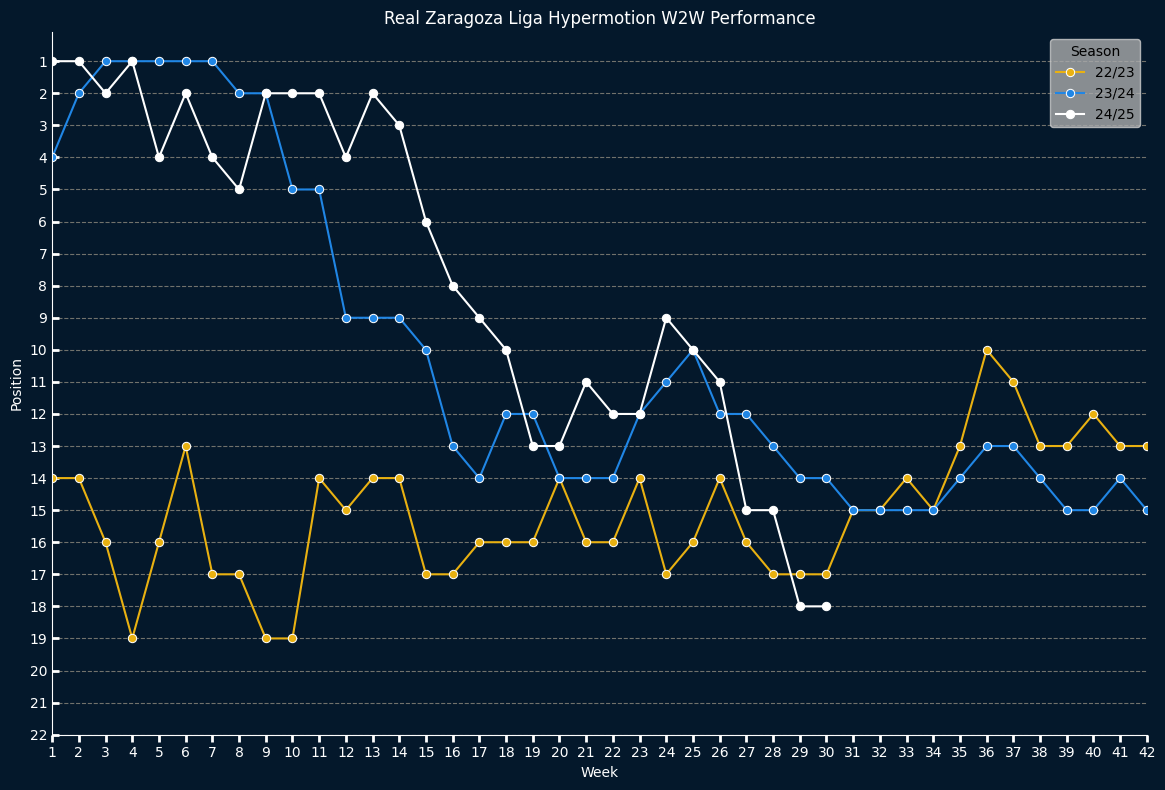

In [29]:
# Create the fig
fig = plt.figure(figsize=(12, 8))

# Create lineplots for all seasons
sns.lineplot(data=df_2223, x='week', y='position', marker='o', color='#E9B111', label='22/23')
sns.lineplot(data=df_2324, x='week', y='position', marker='o', color='#2086E5', label='23/24')
sns.lineplot(data=df_2425, x='week', y='position', marker='o', color='#FFFFFF', label='24/25')

# Configure Y axis to match league positions
plt.yticks(ticks=range(1, 23, 1))

# Invert axis to go from 22 to 1
plt.gca().invert_yaxis()

plt.xticks(ticks=range(0, 43, 1))  # Change X axis ticks to match all matchweeks
plt.xlim(1, 42)  # Limit the X axis to the last matchweek

# Labels and title
plt.xlabel('Week', color='white')
plt.ylabel('Position', color='white')
plt.title('Real Zaragoza Liga Hypermotion W2W Performance', color='white')
plt.grid(color='#dfccae', linestyle='--', axis='y', alpha=.5)

# get the axis
ax = plt.gca()

# Delete top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
matplotlib.rcParams['axes.edgecolor'] = 'white'

# Change BG color
ax.set_facecolor('#04182B')

fig.patch.set_facecolor('#04182B')

# Edit both axis ticks
ax.tick_params(axis='x', colors='white', direction='out', length=5, width=2)
ax.tick_params(axis='y', colors='white', direction='in', length=5, width=2)

#Adjust right margin of the fig
plt.subplots_adjust(right=0.15) 

#Add and customize legend
plt.legend(loc='upper right', frameon=True, title='Season', facecolor='#AAABAC')  # frameon: add a bg to the legend

plt.tight_layout()  # Auto


In [30]:
#SCRAPE LALIGA FUNC
def laliga2_scrape(url):
    """
    Scrap Laliga Fotmob data and return a df with all finished matches
        
    Returns:
        pd.DataFrame: DataFrame w/ clean data.
    """
    try:
        r = requests.get(url)

        if r.status_code != 200:
            print("Request error. Status code:", r.status_code)
            return None

        soup = BeautifulSoup(r.text, 'html.parser')
        script_tag = soup.find('script', attrs={'id': '__NEXT_DATA__'})

        if not script_tag:
            print("Structure not found in the webpage.")
            return None

        json_fotmob = json.loads(script_tag.contents[0])
        data_json = json_fotmob['props']['pageProps']['matches']['allMatches']
        league_name = json_fotmob['props']['pageProps']['details']['shortName'].strip()

        # Create list with all the needed data
        df_data = [
            (match['roundName'], match['status']['finished'], league_name,
             match['home']['name'], match['away']['name'], match['status'].get('scoreStr', None))
            for match in data_json
        ]

        # Create the dataframe
        df_laliga = pd.DataFrame(df_data, columns=['matchweek', 'isFinished', 'league', 'local', 'away', 'result'])

        # Drop all unfinished matches
        df_laliga_clean = df_laliga.dropna(subset=['result']).copy()

        return df_laliga_clean

    except Exception as e:
        print("Error en la función de scraping:", str(e))
        return None

In [31]:
#Apply function to scrape all fotmob json

pts_2223 = laliga2_scrape(fotmob_2223)
pts_2324 = laliga2_scrape(fotmob_2324)
pts_2425 = laliga2_scrape(fotmob_2425)

In [32]:
#Function to clean the dataframe

def process_df_fixtures(df):
    df = df[(df["local"] == team) | (df["away"] == team)].copy()

    df.reset_index(inplace=True, drop=True)

    df[['homeScore', 'awayScore']] = df['result'].str.split(' - ', expand=True)
    
    df['homeScore'] = df['homeScore'].astype(int)
    df['awayScore'] = df['awayScore'].astype(int)
    df['matchweek'] = df['matchweek'].astype(int)

    df['winner_team'] = df.apply(lambda row: row['local'] if row['homeScore'] > row['awayScore'] 
                                    else row['away'] if row['homeScore'] < row['awayScore'] 
                                    else "Draw", axis=1)

    df["goal_diff"] = df.apply(lambda row: 
                                    row["homeScore"] - row["awayScore"] if row["local"] == team 
                                    else row["awayScore"] - row["homeScore"] if row["away"] == team 
                                    else 0, axis=1)

    df['goal_diff'] = df['goal_diff'].astype(int)

    df['points'] = df.apply(lambda row:
        3 if (row['winner_team'] == team)else
        1 if (row['winner_team'] == "Draw")else 0,
        axis=1)

    df["points"] = df["points"].cumsum()

    return df

In [33]:
#Apply function to clean the dfs

pts_2223 = process_df_fixtures(pts_2223)
pts_2324 = process_df_fixtures(pts_2324)
pts_2425 = process_df_fixtures(pts_2425)

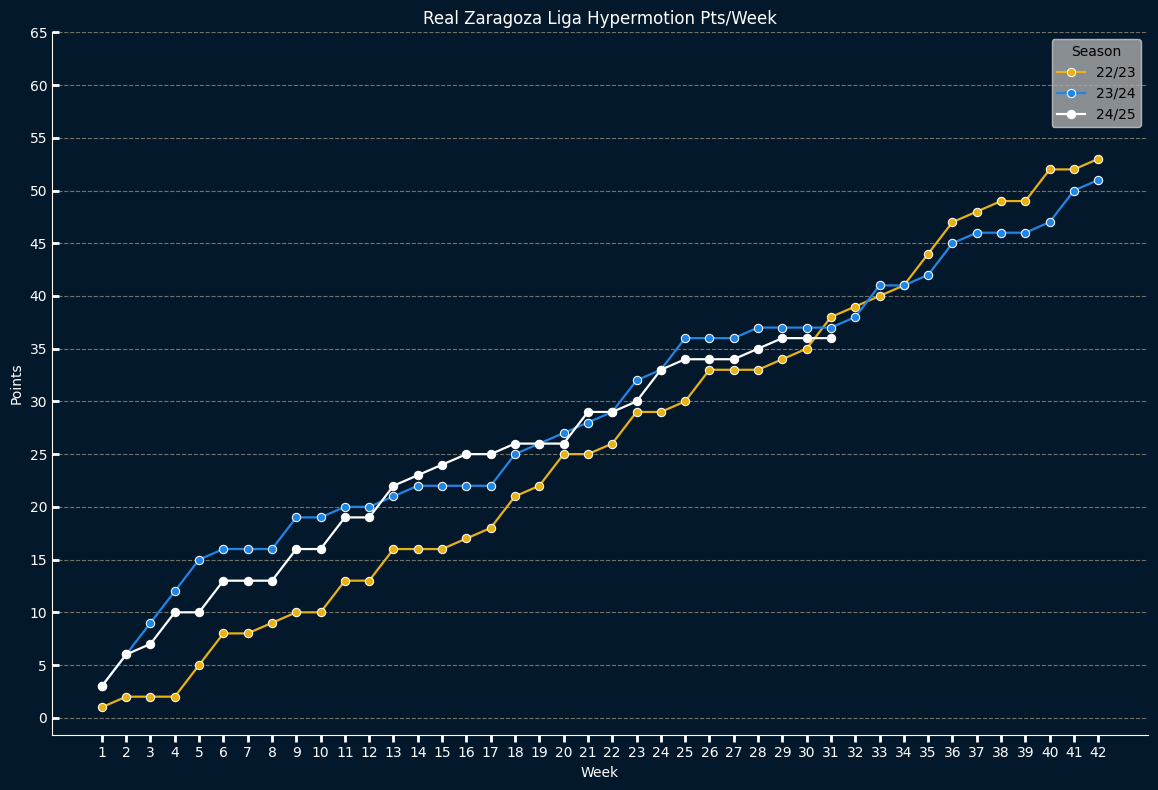

In [34]:
# Create the fig and the lineplots
fig = plt.figure(figsize=(12, 8))

sns.lineplot(data=pts_2223, x='matchweek', y='points', marker='o', linewidth=1.6, color='#E9B111', label='22/23')
sns.lineplot(data=pts_2324, x='matchweek', y='points', marker='o', linewidth=1.6, color='#2086E5', label='23/24')
sns.lineplot(data=pts_2425, x='matchweek', y='points', marker='o', linewidth=1.6, color='#FFFFFF', label='24/25')


# Lables, title & ticks
plt.xlabel('Week', color='white')
plt.ylabel('Points', color='white')
plt.title('Real Zaragoza Liga Hypermotion Pts/Week', color='white')
plt.grid(color='#dfccae', linestyle='--', axis='y', alpha=.5)
plt.yticks(range(0, 70, 5))  #Check if any season surpass the Y limit
plt.xticks(pts_2324['matchweek'])

# Get the axis
ax = plt.gca()

# Delete top & right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
matplotlib.rcParams['axes.edgecolor'] = 'white'

# Set the bg color
ax.set_facecolor('#04182B')
fig.patch.set_facecolor('#04182B')

# Edit axis ticks
ax.tick_params(axis='x', colors='white', direction='out', length=5, width=2)
ax.tick_params(axis='y', colors='white', direction='in', length=5, width=2)

# Adjust fig margin
plt.subplots_adjust(right=0.15) 

# Create and edit the legend
plt.legend(loc='upper right', frameon=True, title='Season', facecolor='#AAABAC') 

plt.tight_layout() 
